In [1]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nibabel as nib
from torch.utils.data import DataLoader
from tqdm import tqdm

from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from gloss_dminus import GlobalLossDminus
from seg_unet import UNet
import torch.nn.functional as F

import json
import statistics
from sklearn.metrics import f1_score
import pickle

## Initialization of the Model

In [2]:
with open('configs/preprocessing_datasets.json') as config_file:
    config_datasets = json.load(config_file)
with open('configs/seg_unet.json') as config_file:
    config_seg = json.load(config_file)

# init W&B
#print("Using W&B in %s mode" % 'online')
#wandb.init(project=config_encoder["model"], mode='online')
seed = config_seg['seed']
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# choose model from config
model = {
    "encoder_pretrain": lambda: EncoderPretrainNet(config_seg),
    "decoder_pretrain": lambda: DecoderPretrainNet(config_seg),
    "seg_unet": lambda: UNet(config_seg),
}[config_seg['model']]()

# choose specified optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config_seg["lr"])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model.to(device)
print("Running model %s" % config_seg["model"])

Using device:  cpu
Running model seg_unet


### initializations of the parameters

In [4]:
version_exp = 'Full_Experiment'
training = True

resize_size = config_seg['resize_size']
n_channels = config_seg['n_channels']
max_epochs = config_seg['max_epochs']
n_classes = config_seg['n_classes']
batch_size = config_seg['batch_size']
n_vol_train = config_seg['n_vol_train']
n_vol_val = config_seg['n_vol_val']
n_vol_test = config_seg['n_vol_test']
weights = torch.tensor([0.1, 0.3, 0.3, 0.3], dtype=torch.float32)

In [5]:
class TrainDataset(torch.utils.data.Dataset) :
    def __init__(self, config, volumes, masks):
        self.path_volumes = volumes
        self.path_masks = masks
        self.n_vols = 1
        
        for i in range(len(self.path_volumes)):
            vol_file = self.path_volumes[i]
            mask_file = self.path_masks[i]

            volume = nib.load(vol_file).get_fdata()
            mask = nib.load(mask_file).get_fdata()
            
            assert volume.shape == mask.shape

            new_img = volume.transpose(2, 0, 1)
            new_mask = mask.transpose(2, 0, 1)
            if i == 0: 
                self.imgs = new_img
                self.masks = new_mask
            else :
                self.imgs = np.concatenate((self.imgs, new_img), axis=0)
                self.masks = np.concatenate((self.masks, new_mask), axis=0)
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.masks[idx]
        

In [6]:
def compute_f1(y_true, y_pred):
   
    y_pred= y_pred.flatten()
    y_true= y_true.flatten()
    f1_val= f1_score(y_true, y_pred, labels =[0,1,2,3],zero_division=0,average=None)
    
    return f1_val[1:]

### initializations of the datasets

In [7]:
img_dataset_train = []
mask_dataset_train = []
for config_dataset in config_datasets :
    if config_dataset['Data'] == 'CIMAS' :        
        for count, path in enumerate(Path(config_dataset['savedir']+'train/').rglob('subject_*/')) :
            if count >= n_vol_train :
                break
            
            if config_dataset["name_mask"] in str(path) or config_dataset["name_img"] in str(path) :
                continue
            for path_image in path.rglob("img.nii.gz") :
                img_dataset_train .append(path_image)
                print(path_image)
            for path_mask in path.rglob("mask.nii.gz") :
                mask_dataset_train.append(path_mask)
                print(path_mask)
            
dataset_train = TrainDataset(config_seg, img_dataset_train, mask_dataset_train)
dataset_loader_train = DataLoader(dataset_train,
                            num_workers=1,
                            batch_size=config_seg['batch_size'],
                            shuffle=True,
                            drop_last=False)


img_dataset_val = []
mask_dataset_val = []
for config_dataset in config_datasets :
    if config_dataset['Data'] == 'CIMAS' :        
        for count, path in enumerate(Path(config_dataset['savedir']+'validation/').rglob('subject_*/')) :
            if count >= n_vol_val :
                break
            
            if config_dataset["name_mask"] in str(path) or config_dataset["name_img"] in str(path) :
                continue
            for path_image in path.rglob("img.nii.gz") :
                img_dataset_val .append(path_image)
            for path_mask in path.rglob("mask.nii.gz") :
                mask_dataset_val.append(path_mask)

dataset_validation = TrainDataset(config_seg, img_dataset_val,mask_dataset_val)
dataset_loader_validation = DataLoader(dataset_validation,
                            num_workers=1,
                            batch_size=config_seg['batch_size'],
                            #pin_memory=True,
                            shuffle=False,
                            drop_last=False)

img_dataset_test = []
mask_dataset_test = []
for config_dataset in config_datasets :
    if config_dataset['Data'] == 'CIMAS' :        
        for count, path in enumerate(Path(config_dataset['savedir']+'test/').rglob('subject_*/')) :
            if count >= n_vol_test :
                break
            
            if config_dataset["name_mask"] in str(path) or config_dataset["name_img"] in str(path) :
                continue
            for path_image in path.rglob("img.nii.gz") :
                img_dataset_test .append(path_image)
            for path_mask in path.rglob("mask.nii.gz") :
                mask_dataset_test.append(path_mask)

dataset_test = TrainDataset(config_seg, img_dataset_test,mask_dataset_test)
dataset_loader_test = DataLoader(dataset_test,
                            num_workers=1,
                            batch_size=config_seg['batch_size'],
                            #pin_memory=True,
                            shuffle=False,
                            drop_last=False)


../img_cropped/cimas/train/subject_5/img.nii.gz
../img_cropped/cimas/train/subject_5/mask.nii.gz
../img_cropped/cimas/train/subject_6/img.nii.gz
../img_cropped/cimas/train/subject_6/mask.nii.gz


#### setup path to save files

In [8]:
def initialize_and_plot(save_directory):
    
    save_models = save_directory + '/save_models/'
    infile = open(save_directory + '/losses.pkl','rb')
    losses = pickle.load(infile)

    infile = open(save_directory + '/f1_scores.pkl','rb')
    f1_scores = pickle.load(infile)

    losses_min = losses.loc[losses['validation loss'] == losses['validation loss'].min()]

    plt.figure()
    losses.plot(x = 'epoch', y =['train loss','validation loss'],mark_right=False)
    plt.savefig(save_directory + '/loss.png')


    f1_max = f1_scores.loc[f1_scores['validation dice'] == f1_scores['validation dice'].max()]
    print('best model found at epoch : ',f1_max['epoch'].item(), 
          ', with train dice : ', f1_max['train dice'].item(),
          ', and validation dice : ', f1_max['validation dice'].item())

    plt.figure()
    f1_scores.plot(x = 'epoch', y =['train dice','validation dice'],mark_right=False)
    plt.savefig(save_directory + '/f1.png')
    
    return save_models , losses, f1_scores, losses_min, f1_max

In [24]:
def run_test_f1(save_models, f1_scores):
    epoch = f1_scores.loc[f1_scores['validation dice'] == f1_scores['validation dice'].max()]['epoch'].item()
    #epoch = losses.loc[losses['validation loss'] == losses['validation loss'].min()]['epoch'].item()

    best_model = {"encoder_pretrain": lambda: EncoderPretrainNet(config_seg),
        "decoder_pretrain": lambda: DecoderPretrainNet(config_seg),
        "seg_unet": lambda: UNet(config_seg),}[config_seg['model']]()
    name = str(save_models)+ 'checkpoints_' + str(epoch) + '.pt'
    checkpoint = torch.load(name, map_location=torch.device('cpu') )
    best_model.load_state_dict(checkpoint['model_state_dict'])

    best_model.eval()

    print("Epoch {:03d}".format(epoch))

    batch_train_loss = []
    f1_mean = []
    f1_arr = []
    for id_batch, (batch_x, batch_y) in enumerate(tqdm(dataset_loader_test)):

        optimizer.zero_grad()
        criterion = {"global_dminus": lambda: GlobalLossDminus(config_seg, 'train'),
                        "global_d": lambda: GlobalLossD(config_seg),
                        "loccont_loss": lambda: LocalContrastiveLoss(config_seg),
                        "crossentropy": lambda: nn.CrossEntropyLoss(weights.to(device)),
                     }[config_seg['loss']]()
        # augment batches by random two separate random transforms

        test_batch_x = batch_x.float().to(device)
        test_batch_x = test_batch_x.view((-1, n_channels, *resize_size))

        test_batch_y = batch_y.long().to(device)
        test_batch_y = test_batch_y.view((-1, n_channels, *resize_size)).squeeze()
        #train_batch_y = torch.tensor(train_batch_y, dtype = torch.long)

        #optimizer.zero_grad(set_to_none=True)
        pred = best_model(test_batch_x)
        pred = F.softmax(pred, dim=1) 
        pred = torch.argmax(pred, dim=1)

        f1_val = compute_f1(test_batch_y, pred)
        f1_mean.append(np.mean(f1_val))
        f1_arr.append(f1_val)

        #fig, axs = plt.subplots(batch_x.shape[0], 3, figsize=(40, 20))
        #for i,img in enumerate(batch_x) :
        #    axs[int(i),0].imshow(img.cpu(), cmap = 'gray') 
        #    axs[int(i),1].imshow(pred[i].cpu(), cmap = 'gray') 
        #    axs[int(i),2].imshow(test_batch_y[i].cpu(), cmap = 'gray') 

        #plt.show()

    f1_mean_epoch = np.mean(f1_mean)
    f1_arr_epoch = np.asarray(f1_arr)
    print('F1 score on test set : ', f1_mean_epoch)
    
    return f1_mean_epoch, epoch


best model found at epoch :  54 , with train dice :  0.9275076859350833 , and validation dice :  0.5309454661538842


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 054


100%|██████████| 57/57 [01:12<00:00,  1.28s/it]

F1 score on test set :  0.35184278392668916


<Figure size 432x288 with 0 Axes>

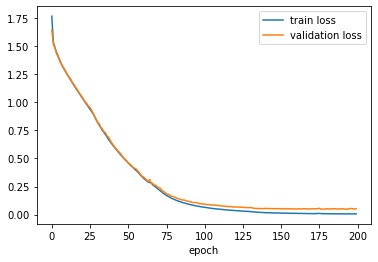

<Figure size 432x288 with 0 Axes>

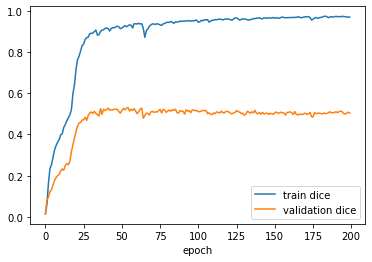

In [27]:
save_directory = './train_model/model pretrained/CIMAS/Full_Experiment/lr_0.0001/8_vol_in_train/2021Jun10_00h03'

lr = 0.0001
n_train = 8
model_used = 'pretrained'

save_models, losses, f1_scores, losses_min, f1_max = initialize_and_plot(save_directory)
f1_mean_epoch, best_epoch = run_test_f1(save_models , f1_scores)

results = results.append([{'model': model_used, 'n vol train': n_train, 'lr' : lr, 
                           'train F1': f1_max['train dice'].item(), 'validation F1' : f1_max['validation dice'].item(), 'test F1' : f1_mean_epoch, 
                           'train loss' : losses_min['train loss'].item(), 'validation loss' : losses_min['validation loss'].item(), 'best epoch' : best_epoch }])

In [202]:
results.to_pickle("./train_model/baseline/Full_Experiment/CIMAS/results.pkl")

In [ ]:
infile = open('./train_model/baseline/Full_Experiment/CIMAS/results.pkl','rb')
results = pickle.load(infile)
results

In [178]:
results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])

best model found at epoch :  170 , with train dice :  0.979781937625561 , and validation dice :  0.5563899318300743


,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch
0,baseline,2,0.001,None,0.894834,0.535280,0.335312,0.016681,0.035283,150
0,baseline,5,0.001,None,0.908003,0.576221,0.418168,0.014342,0.021994,75
0,baseline,8,0.001,None,0.938501,0.582813,0.380678,0.010592,0.026920,92
0,option_2,2,0.001,1,0.912522,0.516595,0.227129,0.018114,0.042575,76
0,option_2,5,0.001,1,0.978049,0.587648,0.377773,0.013165,0.030641,186
0,option_2,8,0.001,1,0.969974,0.572071,0.387617,0.020332,0.024969,56
0,option_2,2,0.001,2,0.896572,0.520824,0.286126,0.017988,0.041025,106
0,option_2,5,0.001,2,0.898555,0.554979,0.370030,0.014105,0.027049,14
0,option_2,8,0.001,2,0.960345,0.576749,0.405029,0.018998,0.026516,34
0,option_2,2,0.001,5,0.942855,0.528717,0.300780,0.016379,0.041944,115


<Figure size 432x288 with 0 Axes>

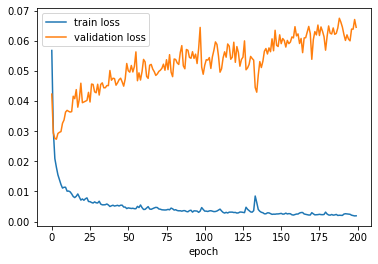

<Figure size 432x288 with 0 Axes>

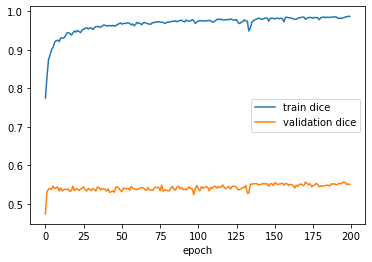

In [201]:
save_directory = './train_model/option_2/5wgt/CIMAS/Full_Experiment/lr_0.001/8_vol_in_train/2021Jun11_21h14'

save_models, losses, f1_scores, losses_min, f1_max = initialize_and_plot(save_directory)

#lr = 0.001
#n_train = 8
#model_used = 'baseline'

#f1_mean_epoch, best_epoch = run_test_f1(save_models , f1_scores)

#results = results.append([{'model': model_used, 'n vol train': n_train, 'lr' : lr, 'wgt_pretrain' : None, 'best epoch' : best_epoch,
#                           'train F1': f1_max['train dice'].item(), 'validation F1' : f1_max['validation dice'].item(), 'test F1' : f1_mean_epoch, 
#                           'train loss' : losses_min['train loss'].item(), 'validation loss' : losses_min['validation loss'].item()}])


infile = open(save_directory + '/results.pkl','rb')
results_BN = pickle.load(infile)
results = results.append(results_BN)
results

In [203]:
results

,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch
0,baseline,2,0.001,None,0.894834,0.535280,0.335312,0.016681,0.035283,150
0,baseline,5,0.001,None,0.908003,0.576221,0.418168,0.014342,0.021994,75
0,baseline,8,0.001,None,0.938501,0.582813,0.380678,0.010592,0.026920,92
0,option_2,2,0.001,1,0.912522,0.516595,0.227129,0.018114,0.042575,76
0,option_2,5,0.001,1,0.978049,0.587648,0.377773,0.013165,0.030641,186
0,option_2,8,0.001,1,0.969974,0.572071,0.387617,0.020332,0.024969,56
0,option_2,2,0.001,2,0.896572,0.520824,0.286126,0.017988,0.041025,106
0,option_2,5,0.001,2,0.898555,0.554979,0.370030,0.014105,0.027049,14
0,option_2,8,0.001,2,0.960345,0.576749,0.405029,0.018998,0.026516,34
0,option_2,2,0.001,5,0.942855,0.528717,0.300780,0.016379,0.041944,115


In [166]:
results[ results['wgt_pretrain'] == 5]

,model,n vol train,lr,train F1,validation F1,test F1,train loss,validation loss,best epoch,wgt_pretrain
0,pretrained BN,2,0.001,0.968175,0.512746,0.313878,0.016057,0.043539,192,5.0
0,pretrained BN,5,0.001,0.888668,0.561751,0.312619,0.018053,0.028283,128,5.0


In [183]:
results['n vol train'].loc[results['best epoch'] == 75] = 5

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [229]:
results['model'].loc[(results['model'] == 'option_2') & (results['wgt_pretrain'] == 5)] = 'pretrained, w=5'

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [230]:
results

,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch
0,baseline,2,0.001,None,0.894834,0.535280,0.335312,0.016681,0.035283,150
0,baseline,5,0.001,None,0.908003,0.576221,0.418168,0.014342,0.021994,75
0,baseline,8,0.001,None,0.938501,0.582813,0.380678,0.010592,0.026920,92
0,"pretrained, w=1",2,0.001,1,0.912522,0.516595,0.227129,0.018114,0.042575,76
0,"pretrained, w=1",5,0.001,1,0.978049,0.587648,0.377773,0.013165,0.030641,186
0,"pretrained, w=1",8,0.001,1,0.969974,0.572071,0.387617,0.020332,0.024969,56
0,"pretrained, w=2",2,0.001,2,0.896572,0.520824,0.286126,0.017988,0.041025,106
0,"pretrained, w=2",5,0.001,2,0.898555,0.554979,0.370030,0.014105,0.027049,14
0,"pretrained, w=2",8,0.001,2,0.960345,0.576749,0.405029,0.018998,0.026516,34
0,"pretrained, w=5",2,0.001,5,0.942855,0.528717,0.300780,0.016379,0.041944,115


In [ ]:
df=pd.DataFrame(earnings,index=employees)

df.plot(kind="bar",stacked=True,figsize=(10,8))
plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

In [253]:
results

,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch
0,baseline,2,0.001,None,0.894834,0.535280,0.335312,0.016681,0.035283,150
0,baseline,5,0.001,None,0.908003,0.576221,0.418168,0.014342,0.021994,75
0,baseline,8,0.001,None,0.938501,0.582813,0.380678,0.010592,0.026920,92
0,"pretrained, w=1",2,0.001,1,0.912522,0.516595,0.227129,0.018114,0.042575,76
0,"pretrained, w=1",5,0.001,1,0.978049,0.587648,0.377773,0.013165,0.030641,186
0,"pretrained, w=1",8,0.001,1,0.969974,0.572071,0.387617,0.020332,0.024969,56
0,"pretrained, w=2",2,0.001,2,0.896572,0.520824,0.286126,0.017988,0.041025,106
0,"pretrained, w=2",5,0.001,2,0.898555,0.554979,0.370030,0.014105,0.027049,14
0,"pretrained, w=2",8,0.001,2,0.960345,0.576749,0.405029,0.018998,0.026516,34
0,"pretrained, w=5",2,0.001,5,0.942855,0.528717,0.300780,0.016379,0.041944,115


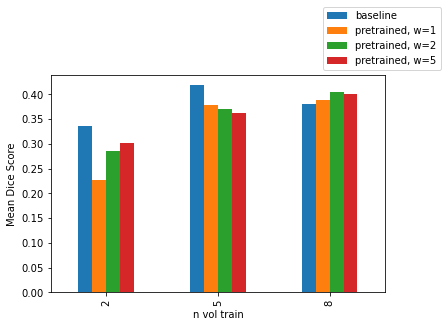

In [292]:
results_test = results[['n vol train', 'test F1']].loc[results['model'] == 'baseline']
results_test.columns = ['n vol train','baseline']
results_test['pretrained, w=1'] = results['test F1'].loc[results['model'] == 'pretrained, w=1']
results_test['pretrained, w=2'] = results['test F1'].loc[results['model'] == 'pretrained, w=2']
results_test['pretrained, w=5'] = results['test F1'].loc[results['model'] == 'pretrained, w=5']
results_test

ax = results_test.plot(kind = 'bar', x = 'n vol train', stacked=False)
lgd = plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
ax.set_ylabel("Mean Dice Score")
plt.savefig("./train_model/CIMAS/MeanDiceScore_test.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

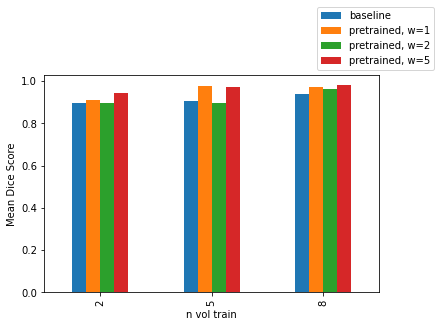

In [290]:
results_train = results[['n vol train', 'train F1']].loc[results['model'] == 'baseline']
results_train.columns = ['n vol train','baseline']
results_train['pretrained, w=1'] = results['train F1'].loc[results['model'] == 'pretrained, w=1']
results_train['pretrained, w=2'] = results['train F1'].loc[results['model'] == 'pretrained, w=2']
results_train['pretrained, w=5'] = results['train F1'].loc[results['model'] == 'pretrained, w=5']
results_train

ax = results_train.plot(kind = 'bar', x = 'n vol train', stacked=False)
lgd = plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
ax.set_ylabel("Mean Dice Score")
plt.savefig("./train_model/CIMAS/MeanDiceScore_train.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

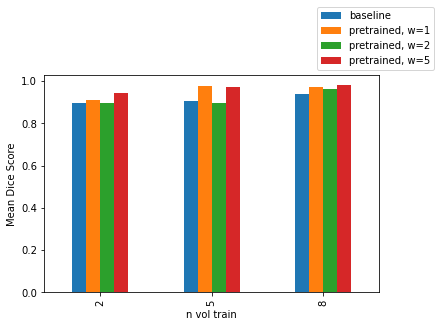

In [291]:
results_val = results[['n vol train', 'validation F1']].loc[results['model'] == 'baseline']
results_val.columns = ['n vol train','baseline']
results_val['pretrained, w=1'] = results['validation F1'].loc[results['model'] == 'pretrained, w=1']
results_val['pretrained, w=2'] = results['validation F1'].loc[results['model'] == 'pretrained, w=2']
results_val['pretrained, w=5'] = results['validation F1'].loc[results['model'] == 'pretrained, w=5']
results_val

ax = results_train.plot(kind = 'bar', x = 'n vol train', stacked=False)
lgd = plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
ax.set_ylabel("Mean Dice Score")
plt.savefig("./train_model/CIMAS/MeanDiceScore_validation.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [293]:
results_2 = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])

best model found at epoch :  46 , with train dice :  0.8659980382312632 , and validation dice :  0.03762490541519608


,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch
0,baseline,1,0.001,None,0.851927,0.078296,0.059837,0.093500,0.331370,37
0,option_2,1,0.001,1,0.345141,0.018452,0.034189,0.088347,0.313245,7
0,option_2,1,0.001,2,0.939680,0.018808,0.030123,0.083270,0.316259,108
0,option_2,1,0.001,5,0.865998,0.037625,0.043936,0.081183,0.312330,46


<Figure size 432x288 with 0 Axes>

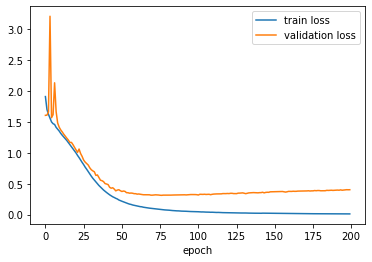

<Figure size 432x288 with 0 Axes>

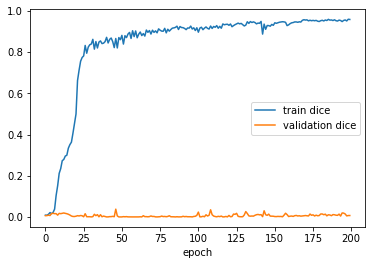

In [298]:
save_directory = './train_model/CIMAS_2nd_config/option_2/wgt_5/lr_0.001/1_vol_in_train/2_vol_in_val'

save_models, losses, f1_scores, losses_min, f1_max = initialize_and_plot(save_directory)

infile = open(save_directory + '/results.pkl','rb')
results_BN = pickle.load(infile)
results_2 = results_2.append(results_BN)
results_2

In [299]:
results_3 = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])

best model found at epoch :  69 , with train dice :  0.8089490063856726 , and validation dice :  0.3441945488077012


,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch
0,option_2,2,0.001,1,0.902802,0.361647,0.458576,0.017203,0.110876,112
0,option_2,2,0.001,2,0.900772,0.245950,0.344207,0.024711,0.155257,75
0,option_2,2,0.001,5,0.870293,0.248182,0.317033,0.035714,0.159952,53
0,baseline,2,0.001,None,0.808949,0.344195,0.394785,0.029672,0.089825,69


<Figure size 432x288 with 0 Axes>

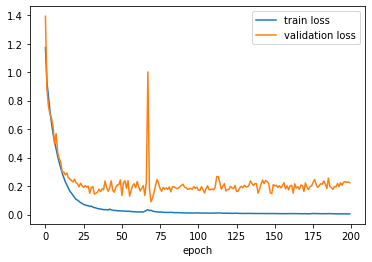

<Figure size 432x288 with 0 Axes>

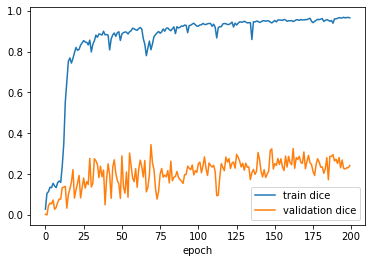

In [304]:
save_directory = './train_model/CIMAS_2nd_config/baseline/lr_0.001/2_vol_in_train/2_vol_in_val'
#save_directory = './train_model/CIMAS_2nd_config/option_2/wgt_5/lr_0.001/2_vol_in_train/2_vol_in_val'

save_models, losses, f1_scores, losses_min, f1_max = initialize_and_plot(save_directory)

infile = open(save_directory + '/results.pkl','rb')
results_BN = pickle.load(infile)
results_3 = results_3.append(results_BN)
results_3

In [323]:
results_4 = results_2.append(results_3)
results_4

,model,n vol train,lr,wgt_pretrain,train F1,validation F1,test F1,train loss,validation loss,best epoch
0,baseline,1,0.001,None,0.851927,0.078296,0.059837,0.093500,0.331370,37
0,option_2,1,0.001,1,0.345141,0.018452,0.034189,0.088347,0.313245,7
0,option_2,1,0.001,2,0.939680,0.018808,0.030123,0.083270,0.316259,108
0,option_2,1,0.001,5,0.865998,0.037625,0.043936,0.081183,0.312330,46
0,option_2,2,0.001,1,0.902802,0.361647,0.458576,0.017203,0.110876,112
0,option_2,2,0.001,2,0.900772,0.245950,0.344207,0.024711,0.155257,75
0,option_2,2,0.001,5,0.870293,0.248182,0.317033,0.035714,0.159952,53
0,baseline,2,0.001,None,0.808949,0.344195,0.394785,0.029672,0.089825,69


In [312]:
results_test

,n vol train,baseline,"pretrained, w=1","pretrained, w=2","pretrained, w=5"
0,2,0.335312,0.227129,0.286126,0.300780
0,5,0.418168,0.377773,0.370030,0.362890
0,8,0.380678,0.387617,0.405029,0.400713


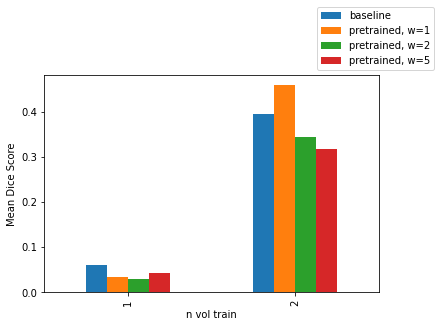

In [324]:
results_test = results_4[['n vol train', 'test F1']].loc[results_4['model'] == 'baseline']
results_test.columns = ['n vol train','baseline']
results_test['pretrained, w=1'] = results_4['test F1'].loc[(results_4['model'] == 'option_2') & (results_4['wgt_pretrain'] == 1)]
results_test['pretrained, w=2'] = results_4['test F1'].loc[(results_4['model'] == 'option_2') & (results_4['wgt_pretrain'] == 2)]
results_test['pretrained, w=5'] = results_4['test F1'].loc[(results_4['model'] == 'option_2') & (results_4['wgt_pretrain'] == 5)]
results_test

ax = results_test.plot(kind = 'bar', x = 'n vol train', stacked=False)
lgd = plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
ax.set_ylabel("Mean Dice Score")
plt.savefig("./train_model/CIMAS/MeanDiceScore_test.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
results_test['pretrained, w=1'] = results_3['test F1'].loc[results_3['model'] == 'option_2' & results_3['wgt_pretrain'] == 1]
results_test['pretrained, w=2'] = results_3['test F1'].loc[results_3['model'] == 'option_2' & results_3['wgt_pretrain'] == 2]
results_test['pretrained, w=5'] = results_3['test F1'].loc[results_3['model'] == 'option_2' & results_3['wgt_pretrain'] == 5]
results_test

ax = results_test.plot(kind = 'bar', x = 'model', stacked=False)
lgd = plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
ax.set_ylabel("Mean Dice Score")
plt.savefig("./train_model/CIMAS/MeanDiceScore_test.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

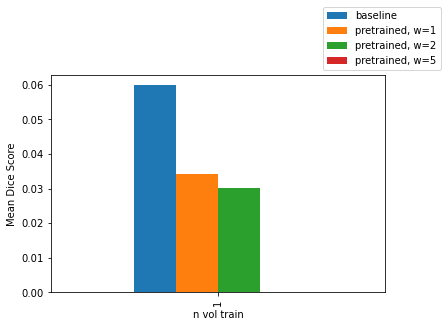

In [320]:
results_test = results_2[['n vol train', 'test F1']].loc[results_2['model'] == 'baseline']
results_test.columns = ['n vol train','baseline']
results_test['pretrained, w=1'] = results_2['test F1'].loc[(results_3['model'] == 'option_2') & (results_2['wgt_pretrain'] == 1)]
results_test['pretrained, w=2'] = results_2['test F1'].loc[(results_3['model'] == 'option_2') & (results_2['wgt_pretrain'] == 2)]
results_test['pretrained, w=5'] = results_2['test F1'].loc[(results_3['model'] == 'option_2') & (results_2['wgt_pretrain'] == 5)]
results_test

ax = results_test.plot(kind = 'bar', x = 'n vol train', stacked=False)
lgd = plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
ax.set_ylabel("Mean Dice Score")
plt.savefig("./train_model/CIMAS/MeanDiceScore_test.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
test_volume = '../img_cropped/cimas/test/subject_0/img.nii.gz'

img_dataset_test = []
mask_dataset_test = []
for config_dataset in config_datasets :
    if config_dataset['Data'] == 'CIMAS' :        
        for count, path in enumerate(Path(config_dataset['savedir']+'test/').rglob('subject_*/')) :
            if count >= n_vol_test :
                break
            
            if config_dataset["name_mask"] in str(path) or config_dataset["name_img"] in str(path) :
                continue
            for path_image in path.rglob("img.nii.gz") :
                img_dataset_test .append(path_image)
            for path_mask in path.rglob("mask.nii.gz") :
                mask_dataset_test.append(path_mask)

dataset_test = TrainDataset(config_seg, img_dataset_test,mask_dataset_test)
dataset_loader_test = DataLoader(dataset_test,
                            num_workers=1,
                            batch_size=config_seg['batch_size'],
                            #pin_memory=True,
                            shuffle=False,
                            drop_last=False)

class TestDataset(torch.utils.data.Dataset) :
    def __init__(self, config, volumes, masks):
        self.path_volumes = volumes
        self.path_masks = masks
        self.n_vols = 1
        
        for i in range(len(self.path_volumes)):
            vol_file = self.path_volumes[i]
            mask_file = self.path_masks[i]

            volume = nib.load(vol_file).get_fdata()
            mask = nib.load(mask_file).get_fdata()
            
            assert volume.shape == mask.shape

            new_img = volume.transpose(2, 0, 1)
            new_mask = mask.transpose(2, 0, 1)
            if i == 0: 
                self.imgs = new_img
                self.masks = new_mask
            else :
                self.imgs = np.concatenate((self.imgs, new_img), axis=0)
                self.masks = np.concatenate((self.masks, new_mask), axis=0)
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.masks[idx]
        

In [ ]:
vol_file = '../img_cropped/cimas/test/subject_0/img.nii.gz'
mask_file = '../img_cropped/cimas/test/subject_0/mask.nii.gz'

volume_test = nib.load(vol_file)
volume = volume_test.get_fdata()
mask = nib.load(mask_file).get_fdata()

assert volume.shape == mask.shape

new_img = volume.transpose(2, 0, 1)
new_mask = mask.transpose(2, 0, 1)

imgs = new_img
masks = new_mask

In [ ]:
type(volume)

In [ ]:
for index, img in enumerate(imgs) :
    
    optimizer.zero_grad()
    criterion = {"global_dminus": lambda: GlobalLossDminus(config_seg, 'train'),
                    "global_d": lambda: GlobalLossD(config_seg),
                    "loccont_loss": lambda: LocalContrastiveLoss(config_seg),
                    "crossentropy": lambda: nn.CrossEntropyLoss(weights.to(device)),
                 }[config_seg['loss']]()
    
    # augment batches by random two separate random transforms
    img = torch.tensor(img, dtype = torch.float)
    img = img.view((-1, n_channels, *resize_size))
    
    #optimizer.zero_grad(set_to_none=True)
    pred = best_model(img)
    pred = F.softmax(pred, dim=1) 
    pred = torch.argmax(pred, dim=1)
    
    if index == 0 :
        mask_predicted = pred
    else :
        mask_predicted = np.concatenate((mask_predicted, pred), axis=0)
    
print(imgs.shape)
print(mask_predicted.shape)

In [ ]:
mask_transpose = mask_predicted.transpose(1, 2, 0)
mask_transpose.shape

In [ ]:
clipped_img = nib.Nifti1Image(mask_transpose, volume_test.affine, volume_test.header)

In [ ]:
type()

In [ ]:
clipped_img.header.get_data_shape()

In [ ]:
volume_test.header.get_data_shape()

In [ ]:
nib.save(clipped_img, '../img_cropped/cimas/test_mask.nii.gz')  